In [154]:
#importing required libraries and loading csv files into dataframes

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
import renders as rs
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df1=pd.read_csv(r'C:\Users\PallaviM777\Downloads\customers_sample.csv')
df2=pd.read_csv(r'C:\Users\PallaviM777\Downloads\category_spends_sample.csv')
df3=pd.read_csv(r'C:\Users\PallaviM777\Downloads\baskets_sample.csv')
df4=pd.read_csv(r'C:\Users\PallaviM777\Downloads\lineitems_sample.csv')

In [155]:
#Replacing commas
df1['total_spend'] = [x.replace(',','') for x in df1['total_spend']]
df1['average_spend'] = [x.replace(',', '') for x in df1['average_spend']]

for i in list(df2.columns[1:]):
    df2[i] = [x.replace(',', '') for x in df2[i]]

df3['basket_spend'] = [x.replace(',', '') for x in df3['basket_spend']]

df4['spend'] = [x.replace(',', '') for x in df4['spend']]


#Replacing pound sign
df1['total_spend'] = [float(x.replace('£','')) for x in df1['total_spend']]
df1['average_spend'] = [float(x.replace('£','')) for x in df1['average_spend']]

for i in list(df2.columns[1:]):
    df2[i] = [float(x.replace('£','')) for x in df2[i]]

df3['basket_spend'] = [float(x.replace('£','')) for x in df3['basket_spend']]

df4['spend'] = [float(x.replace('£','')) for x in df4['spend']]


#Adding feature to account for average spend per item for each customer
df1['average_item_spend']=df1['total_spend']/df1['total_quantity']

In [156]:
#Group by customer number and category for spend and quantity

df_spend=df4.groupby(['customer_number','category'])['spend'].agg(['sum','count']).reset_index()
df_spend=df_spend.pivot(index='customer_number', columns='category', values='sum').reset_index()
df_spend.fillna(value=0.0,inplace=True)

df_qty=df4.groupby(['customer_number','category'])['quantity'].agg(['sum','count']).reset_index()
df_qty=df_qty.pivot(index='customer_number', columns='category', values='sum').reset_index()
df_qty.fillna(value=0,inplace=True)

df_spend.columns = map(str.lower, df_spend.columns)
df_qty.columns = map(str.lower, df_qty.columns)

#use df_spend as updated category_spend table

In [157]:
#Joining tables for feature selection from tables df_spend and customers_sample

data=df1.join(df_spend.set_index('customer_number'), on='customer_number')

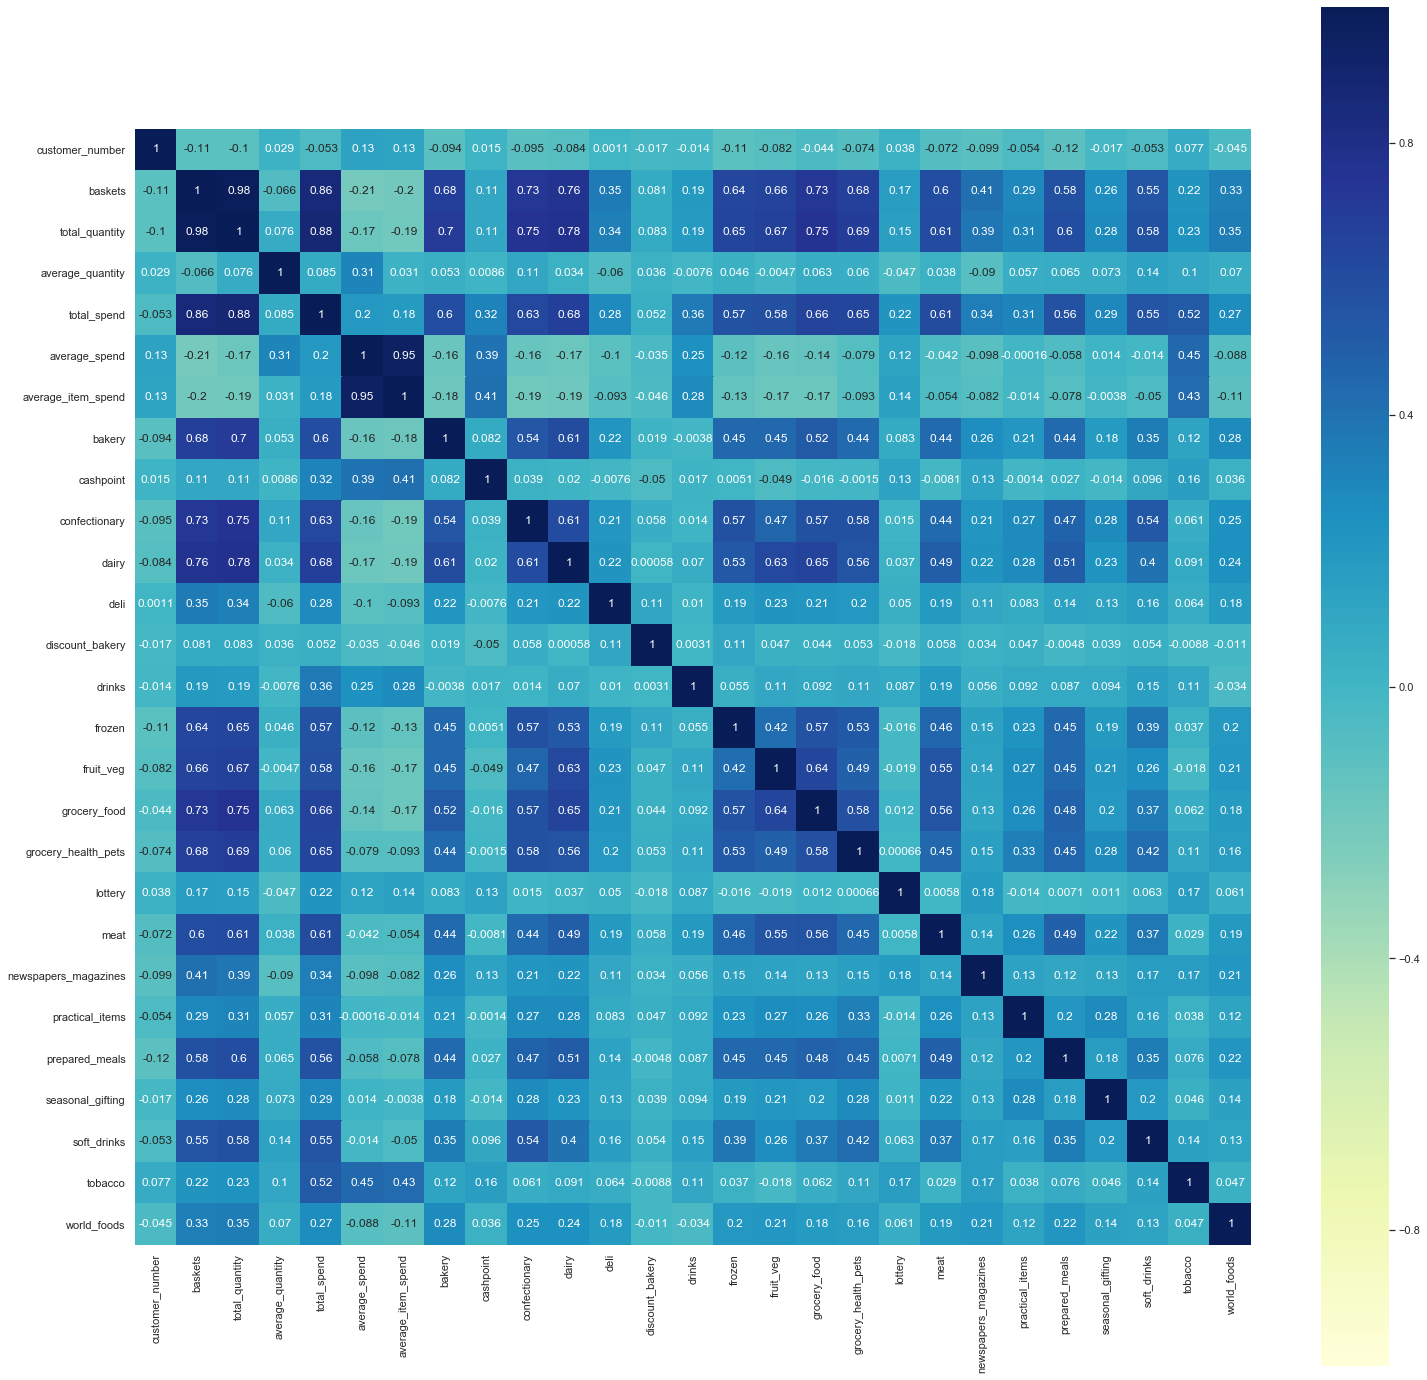

In [158]:
sns.set()
plt.rcParams['figure.figsize'] = (25.0, 25.0)
ax = sns.heatmap(data.corr(),annot=True, cmap="YlGnBu", vmin=-1, vmax=1, square=True, fmt='.2g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [159]:
#Dropping irrelevant features
data.drop(['average_quantity','total_quantity'], axis = 1, inplace = True)

pd.options.display.max_columns = None
data.describe()

customer_number      baskets  total_spend  average_spend  \
count      3000.000000  3000.000000  3000.000000    3000.000000   
mean       8095.724333   487.105000   769.412937       1.682477   
std        4686.259488   332.824524   552.769022       0.733105   
min          14.000000     6.000000     7.280000       0.620000   
25%        4044.750000   257.000000   406.120000       1.260000   
50%        8218.500000   417.000000   627.170000       1.490000   
75%       12115.500000   628.250000   957.675000       1.860000   
max       16316.000000  3119.000000  6588.650000      10.840000   

       average_item_spend       bakery    cashpoint  confectionary  \
count         3000.000000  3000.000000  3000.000000    3000.000000   
mean             1.394845    38.210123    45.330583      57.347793   
std              0.567437    36.496115   123.584361      55.959350   
min              0.558163     0.000000     0.000000       0.000000   
25%              1.070830    14.635000     0.000000      21.070000   
50%              1.251716    29.270000     0.000000      42.290000   
75%              1.533358    50.050000    30.000000      75.125000   
max              7.919243   444.370000  2137.010000     614.370000   

             dairy         deli  discount_bakery       drinks       frozen  \
count  3000.000000  3000.000000      3000.000000  3000.000000  3000.000000   
mean     71.302683    13.736440         1.814837    62.242217    35.466020   
std      57.966265    25.486136         9.450367   121.500365    41.477609   
min       0.000000     0.000000         0.000000     0.000000     0.000000   
25%      31.390000     0.000000         0.000000     0.000000     8.777500   
50%      56.875000     3.495000         0.000000    12.830000    22.275000   
75%      95.327500    15.770000         0.000000    65.150000    47.237500   
max     708.040000   316.190000       173.060000  1005.330000   385.800000   

         fruit_veg  grocery_food  grocery_health_pets      lottery  \
count  3000.000000   3000.000000          3000.000000  3000.000000   
mean     69.456163     60.007530            60.909867    14.165603   
std      70.499654     57.682533            69.805023    48.469754   
min       0.000000      0.000000             0.000000   -74.000000   
25%      22.695000     21.087500            18.145000     0.000000   
50%      50.935000     44.030000            39.075000     0.000000   
75%      93.405000     80.922500            77.250000     6.000000   
max    1262.970000   1017.070000           884.450000   946.000000   

              meat  newspapers_magazines  practical_items  prepared_meals  \
count  3000.000000           3000.000000      3000.000000      3000.00000   
mean     54.740687             16.653390         2.016220        35.48057   
std      67.802126             26.377091         4.322232        41.24047   
min       0.000000              0.000000         0.000000         0.00000   
25%      12.640000              1.500000         0.000000         8.70000   
50%      32.930000              7.345000         0.000000        23.09500   
75%      72.380000             19.687500         2.510000        47.33000   
max     713.280000            351.730000        65.060000       454.29000   

       seasonal_gifting  soft_drinks      tobacco  world_foods  
count       3000.000000  3000.000000  3000.000000  3000.000000  
mean           6.126987    23.303350    92.547613     8.554260  
std           13.104271    35.695592   201.703812    14.757745  
min            0.000000     0.000000     0.000000     0.000000  
25%            0.000000     3.750000     0.000000     0.890000  
50%            1.990000    11.685000     2.030000     3.760000  
75%            6.720000    28.782500    81.030000    10.647500  
max          229.440000   529.650000  2488.940000   321.490000

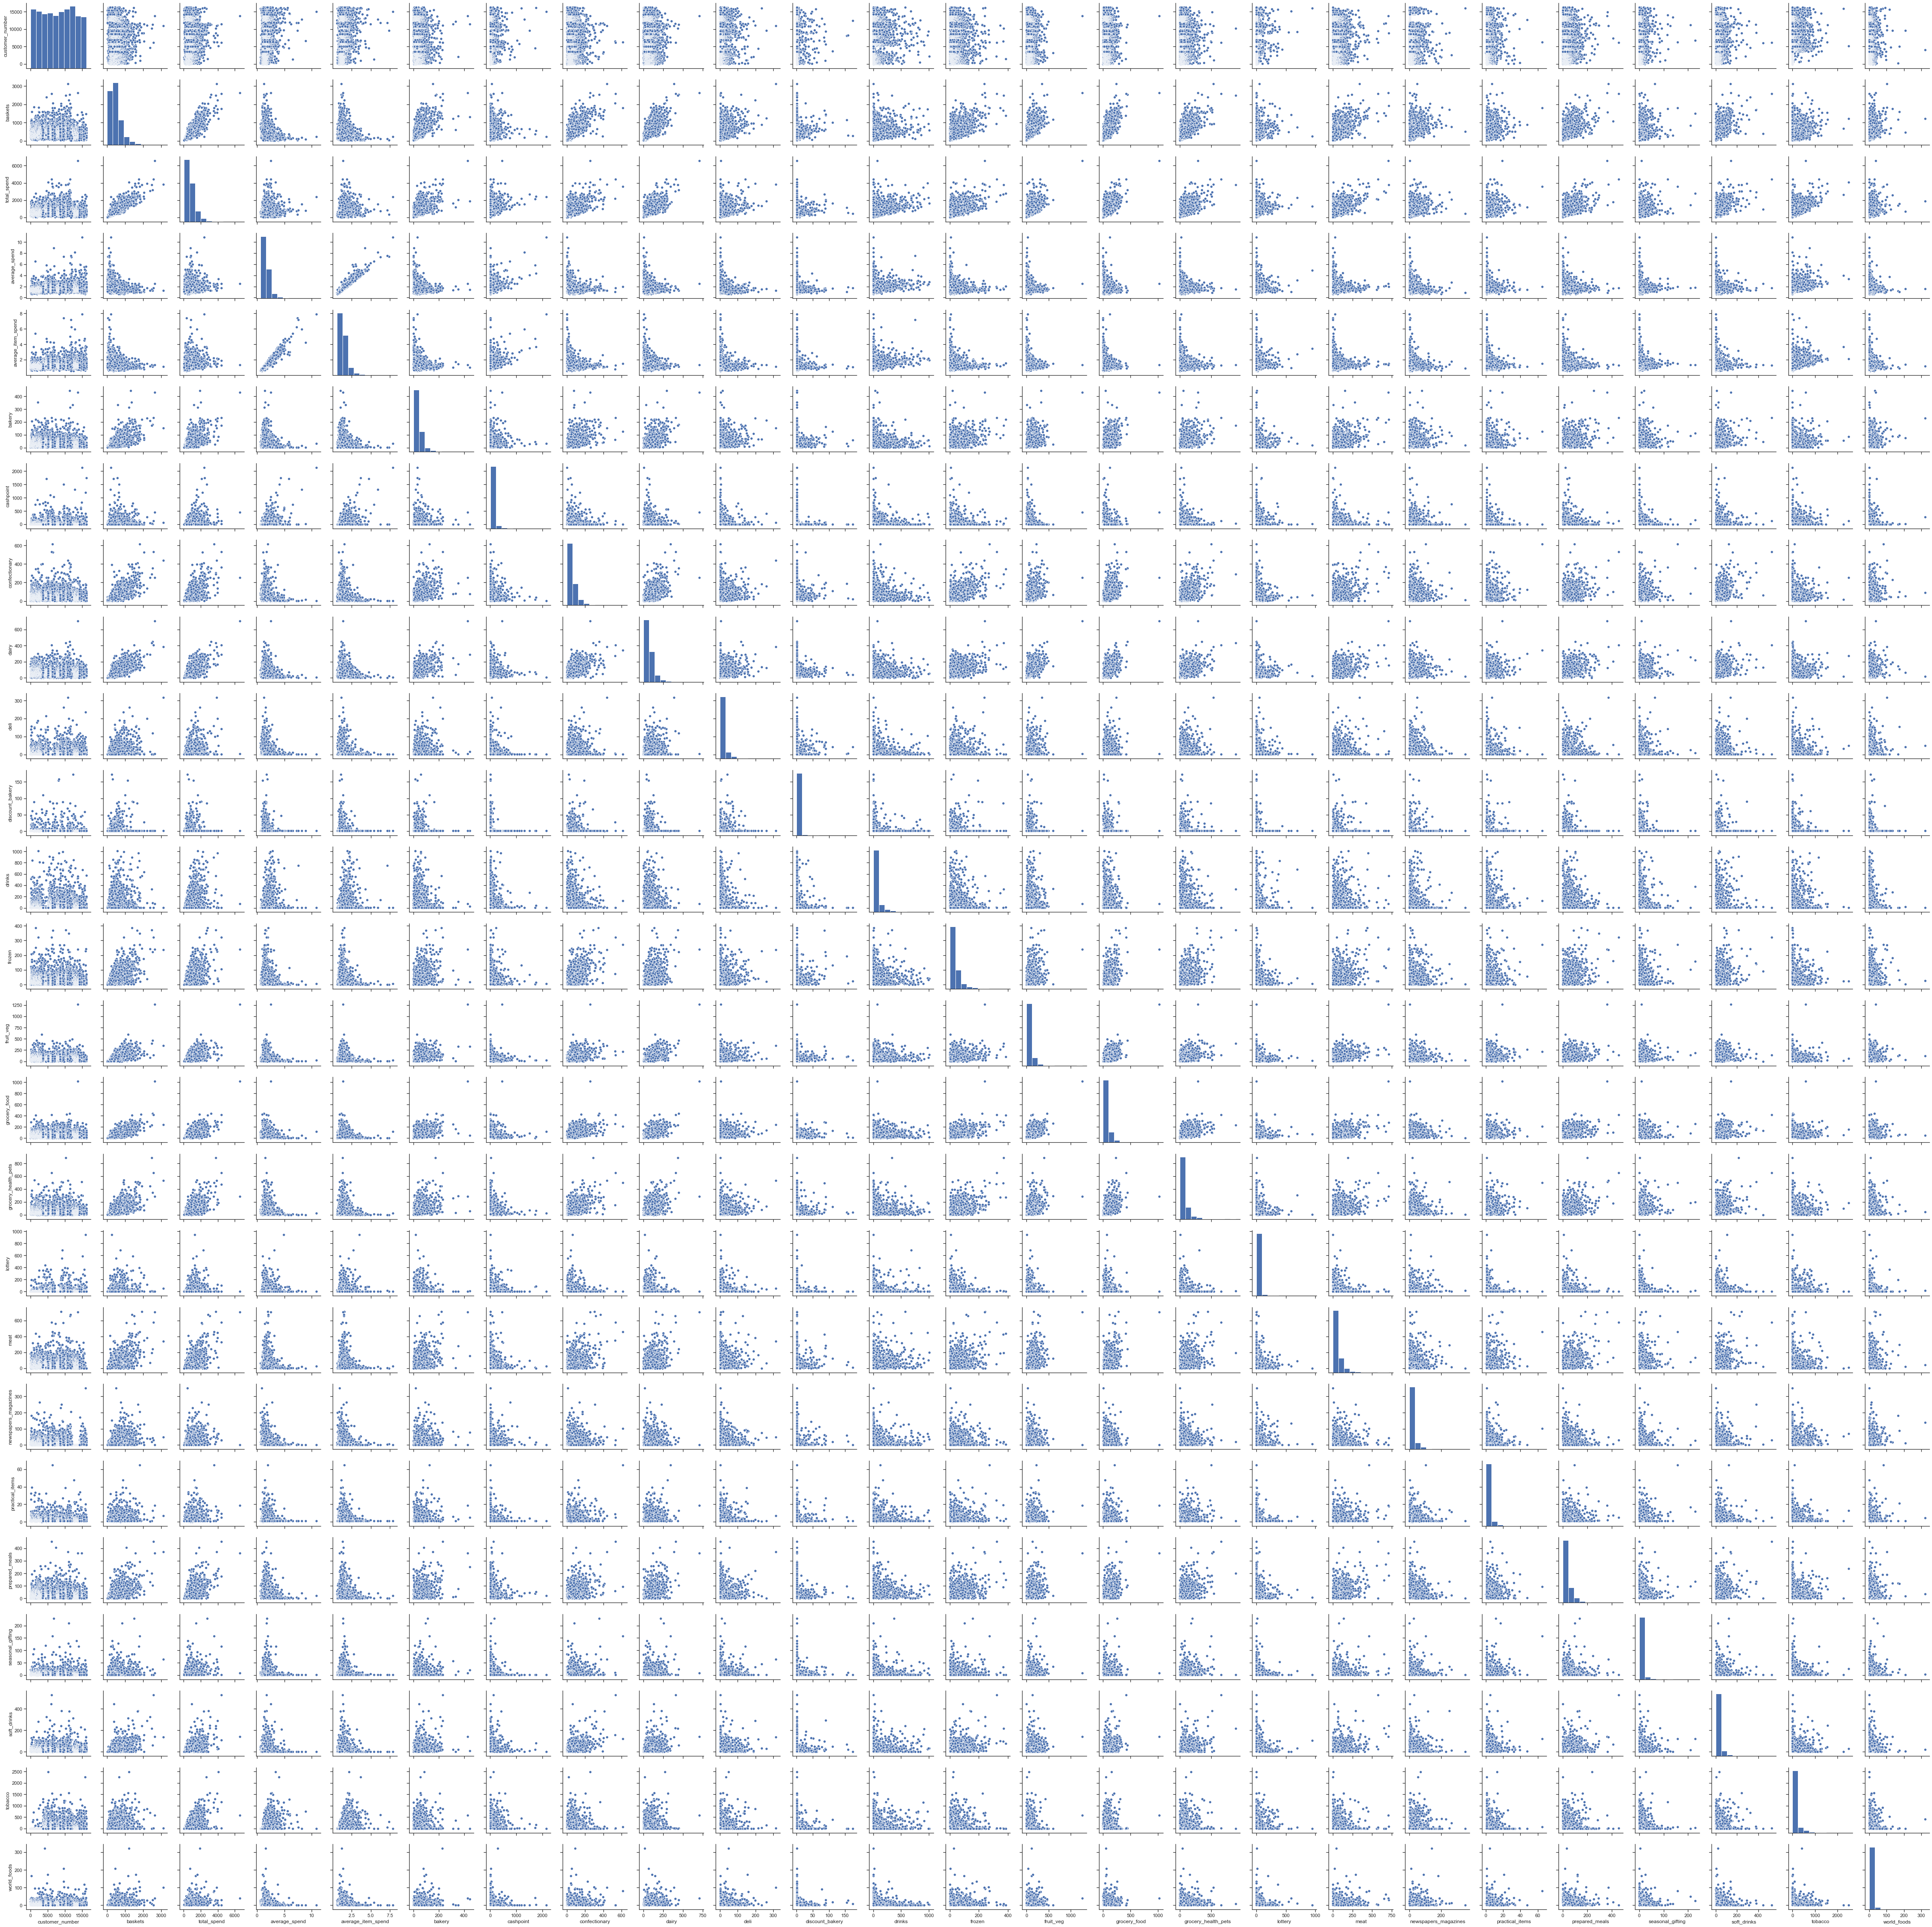

In [168]:
#Visualizing data distribution
sns.set(style="ticks")
sns.pairplot(data)
plt.show()

In [161]:
#Replacing null values in table to 1 for smooth log transformation
for i in data.columns:
    data.loc[data[i]<=0,i]=1

# Scale the data using the natural logarithm
logged_data=pd.DataFrame()
logged_data['customer_number']=data.iloc[:,0]
logged_data[data.columns[1:]] = np.log(data.iloc[:,1:])
logged_data=logged_data.set_index('customer_number')

# Produce a scatter matrix using the logged data...
# scatter = pd.plotting.scatter_matrix(logged_data, figsize = (20,10))

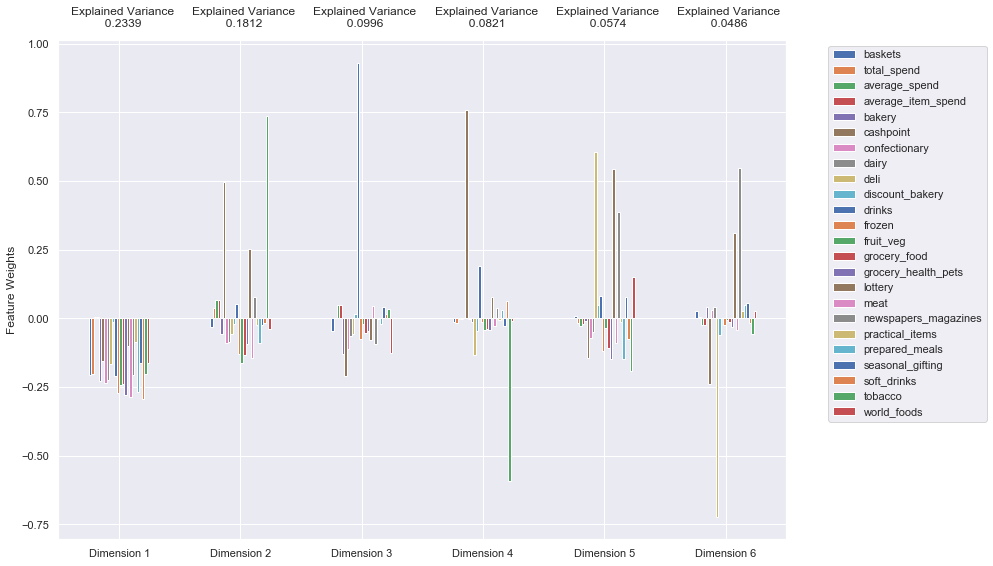

In [162]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(.7)
pca.fit_transform(logged_data)
#-- Generate a PCA results plot 
pca_results = rs.pca_results(logged_data, pca)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()

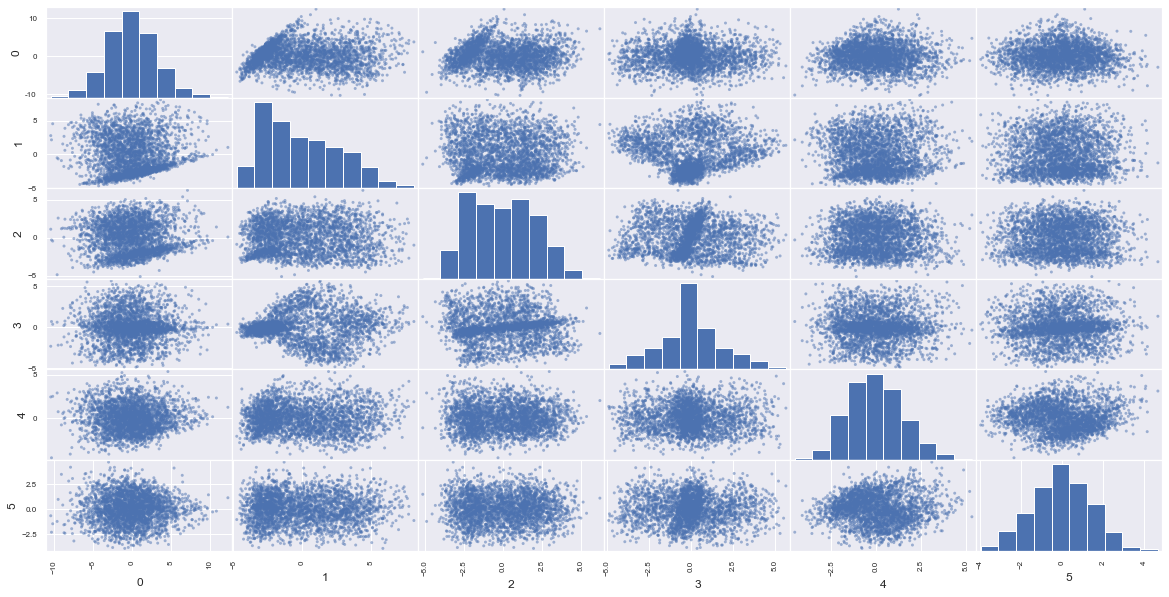

In [163]:
# TODO: Apply PCA by fitting the good data with only two dimensions
# Instantiate
pca = PCA(n_components=6)
pca.fit(logged_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(logged_data)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data)
scatter = pd.plotting.scatter_matrix(reduced_data, figsize = (20,10))

In [164]:
for k in range(5,8):
#-- Create a clusterer that fits to k segments
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(reduced_data)
#-- TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)
#-- Calculate a silhouette score for the 3 segment solution
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(k, score))

For n_clusters = 5. The average silhouette_score is : 0.16640110614954318
For n_clusters = 6. The average silhouette_score is : 0.16772172477241518
For n_clusters = 7. The average silhouette_score is : 0.17188273449822206


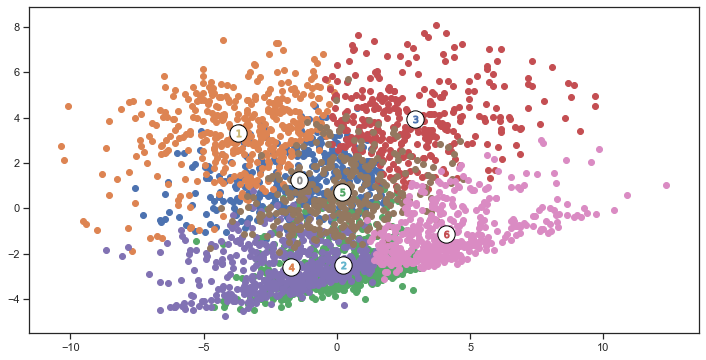

In [169]:
#-- Our final clustering solution
clusterer = KMeans(n_clusters=7).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centres = clusterer.cluster_centers_

#-- Put the predictions into a pandas dataframe format
assignments = pd.DataFrame(preds, columns = ['Cluster'])

#-- Put the predictions into a pandas dataframe format
plot_data = pd.concat([assignments, reduced_data], axis = 1)

#-- Color the points based on assigned cluster (n.b scatter will do this for us automatically)
plt.rcParams['figure.figsize'] = (12.0, 6.0)

for i, c in plot_data.groupby('Cluster'):  
    plt.scatter(c[0], c[1])
    
#-- Plot where the cluster centers are
for i, c in enumerate(centres):
    plt.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', marker = 'o', s=300);
    plt.scatter(x = c[0], y = c[1], marker='${}$'.format(i), alpha = 1, s=50);

In [170]:
# TODO: Inverse transform the centres
log_centres = pca.inverse_transform(centres)

# TODO: Exponentiate the centres
true_centres = np.exp(log_centres)

#-- Display the true centres
segments = ['Segment {}'.format(i) for i in range(0, len(centres))]
true_centres = pd.DataFrame(np.round(true_centres), columns = data.set_index('customer_number').columns)
true_centres.index = segments
print(true_centres)

           baskets  total_spend  average_spend  average_item_spend  bakery  \
Segment 0    502.0        899.0            2.0                 1.0    29.0   
Segment 1    756.0       1441.0            2.0                 2.0    50.0   
Segment 2    440.0        535.0            1.0                 1.0    34.0   
Segment 3    186.0        398.0            2.0                 2.0    10.0   
Segment 4    566.0        786.0            1.0                 1.0    35.0   
Segment 5    366.0        579.0            2.0                 1.0    26.0   
Segment 6    167.0        256.0            2.0                 1.0    10.0   

           cashpoint  confectionary  dairy  deli  discount_bakery  drinks  \
Segment 0        1.0           44.0   62.0   6.0              1.0    20.0   
Segment 1       87.0           68.0   88.0   7.0              1.0    24.0   
Segment 2        1.0           54.0   67.0   5.0              1.0     2.0   
Segment 3       13.0           13.0   19.0   2.0              1.0  

In [204]:
# Join the segment assignments to the original data 
cluster_assignments = pd.concat([assignments, data], axis = 1, join='outer')

# Create a loop that describes summary statistics for each segment
for c, d in cluster_assignments.groupby('Cluster'):  
    print("SEGMENT", int(c))
    display(d.describe())

SEGMENT 0


Cluster  customer_number     baskets  total_spend  average_spend  \
count    383.0       383.000000   383.00000   383.000000     383.000000   
mean       0.0      8596.117493   550.97389   965.113003       1.816919   
std        0.0      3378.512812   273.48797   497.899968       0.574406   
min        0.0       572.000000   187.00000   305.900000       0.950000   
25%        0.0      6011.000000   343.50000   600.750000       1.400000   
50%        0.0      8563.000000   478.00000   835.770000       1.670000   
75%        0.0     10876.500000   691.50000  1247.430000       2.160000   
max        0.0     16165.000000  1800.00000  3676.460000       4.050000   

       average_item_spend      bakery   cashpoint  confectionary       dairy  \
count          383.000000  383.000000  383.000000     383.000000  383.000000   
mean             1.506065   40.090209    2.221932      59.425849   76.572219   
std              0.445350   29.382016    3.822685      47.478032   49.811855   
min              0.788955    0.820000    1.000000       1.000000    7.910000   
25%              1.189433   20.495000    1.000000      25.515000   40.695000   
50%              1.401636   34.250000    1.000000      47.050000   66.960000   
75%              1.738854   52.720000    1.000000      80.000000  100.725000   
max              3.663970  166.120000   25.000000     329.820000  308.190000   

             deli  discount_bakery      drinks      frozen   fruit_veg  \
count  383.000000       383.000000  383.000000  383.000000  383.000000   
mean    17.901932         3.462115   95.629661   40.247076   71.882950   
std     27.617995        10.219282  157.447405   41.333409   57.539133   
min      0.370000         0.370000    0.940000    0.210000    2.090000   
25%      1.000000         1.000000    3.400000   14.435000   35.900000   
50%      6.420000         1.000000   28.050000   26.610000   59.840000   
75%     22.705000         1.000000  109.880000   52.530000   89.070000   
max    235.150000       110.690000  859.350000  267.460000  457.950000   

       grocery_food  grocery_health_pets     lottery        meat  \
count    383.000000           383.000000  383.000000  383.000000   
mean      66.788747            70.545979   16.172846   60.501697   
std       53.748676            67.201994   52.421382   57.968379   
min        3.470000             1.320000    1.000000    0.950000   
25%       28.455000            26.215000    1.000000   21.390000   
50%       49.940000            49.140000    1.000000   46.510000   
75%       87.955000            92.585000    8.000000   80.445000   
max      310.990000           507.590000  690.000000  572.630000   

       newspapers_magazines  practical_items  prepared_meals  \
count            383.000000       383.000000      383.000000   
mean              19.147572         2.680392       39.307572   
std               27.184041         3.682278       38.412124   
min                0.200000         0.320000        0.410000   
25%                2.540000         1.000000       13.420000   
50%                9.720000         1.000000       26.950000   
75%               23.270000         3.040000       50.040000   
max              228.950000        26.990000      212.820000   

       seasonal_gifting  soft_drinks      tobacco  world_foods  
count        383.000000   383.000000   383.000000   383.000000  
mean           8.175561    25.373316   244.007467     9.027520  
std           14.602989    29.157575   268.182054    12.289116  
min            0.440000     0.120000     8.120000     0.020000  
25%            1.000000     5.035000    65.940000     1.085000  
50%            3.380000    14.170000   138.770000     4.270000  
75%            8.420000    35.340000   335.560000    10.460000  
max          137.890000   169.270000  2264.310000    76.830000

SEGMENT 1


Cluster  customer_number      baskets  total_spend  average_spend  \
count    396.0       396.000000   396.000000   396.000000     396.000000   
mean       1.0      8201.906566   803.012626  1431.083283       1.855404   
std        0.0      3092.451232   415.207866   751.148015       0.568592   
min        1.0       792.000000   255.000000   492.220000       0.890000   
25%        1.0      5443.250000   532.000000   915.010000       1.460000   
50%        1.0      8565.000000   681.000000  1247.460000       1.725000   
75%        1.0     10687.500000   949.750000  1749.165000       2.150000   
max        1.0     16203.000000  3119.000000  6588.650000       4.520000   

       average_item_spend      bakery    cashpoint  confectionary       dairy  \
count          396.000000  396.000000   396.000000     396.000000  396.000000   
mean             1.551045   60.367424   162.530934      89.850202  103.977475   
std              0.462281   46.235036   192.912922      75.409753   71.936972   
min              0.791730    3.160000     1.000000       2.930000   15.030000   
25%              1.242498   31.040000    40.000000      43.805000   59.652500   
50%              1.448190   48.465000   100.000000      67.830000   85.685000   
75%              1.798808   73.957500   222.465000     113.540000  128.012500   
max              3.895953  430.500000  1751.900000     614.370000  708.040000   

             deli  discount_bakery      drinks      frozen    fruit_veg  \
count  396.000000       396.000000  396.000000  396.000000   396.000000   
mean    20.901136         2.288182  108.378030   52.715177    82.889596   
std     37.208594         8.952371  171.826755   53.351380    85.076089   
min      0.300000         0.230000    1.000000    0.850000     0.890000   
25%      1.045000         1.000000    4.987500   18.885000    36.927500   
50%      6.230000         1.000000   27.355000   36.325000    65.240000   
75%     23.542500         1.000000  130.365000   66.615000   102.525000   
max    316.190000        89.940000  993.050000  347.110000  1262.970000   

       grocery_food  grocery_health_pets     lottery        meat  \
count    396.000000           396.000000  396.000000  396.000000   
mean      82.913131            98.573207   40.119470   84.656263   
std       78.059424            86.948140   72.509197   96.098087   
min        3.700000             3.550000    1.000000    1.000000   
25%       36.992500            42.785000    1.000000   27.330000   
50%       61.200000            70.715000   10.580000   56.885000   
75%      102.522500           123.027500   43.000000  106.830000   
max     1017.070000           655.760000  438.000000  713.280000   

       newspapers_magazines  practical_items  prepared_meals  \
count            396.000000       396.000000      396.000000   
mean              30.571843         3.304040       55.793030   
std               33.426069         5.086656       54.174238   
min                0.350000         0.420000        0.990000   
25%                8.087500         1.000000       21.210000   
50%               20.830000         1.000000       41.275000   
75%               42.120000         3.640000       73.807500   
max              265.100000        65.060000      454.290000   

       seasonal_gifting  soft_drinks      tobacco  world_foods  
count        396.000000   396.000000   396.000000   396.000000  
mean          10.384091    50.732803   279.431515    13.266338  
std           19.177929    59.129981   309.319528    22.038937  
min            0.420000     0.470000     1.000000     0.560000  
25%            1.090000    14.835000    58.670000     2.580000  
50%            4.710000    30.510000   170.550000     7.995000  
75%           11.560000    67.690000   391.740000    17.390000  
max          229.440000   529.650000  2488.940000   321.490000

SEGMENT 2


Cluster  customer_number      baskets  total_spend  average_spend  \
count    534.0       534.000000   534.000000   534.000000     534.000000   
mean       2.0      7344.207865   510.018727   630.582509       1.270225   
std        0.0      4978.585186   241.680451   291.458941       0.248895   
min        2.0        45.000000   166.000000   226.290000       0.620000   
25%        2.0      2823.250000   332.000000   427.905000       1.100000   
50%        2.0      7249.500000   457.000000   549.330000       1.250000   
75%        2.0     12214.250000   622.000000   759.585000       1.417500   
max        2.0     16281.000000  1646.000000  1957.820000       2.540000   

       average_item_spend      bakery   cashpoint  confectionary       dairy  \
count          534.000000  534.000000  534.000000     534.000000  534.000000   
mean             1.063750   44.106704    2.114232      65.426667   80.240543   
std              0.182234   34.066351    4.311082      46.501159   50.089992   
min              0.589959    0.700000    1.000000       2.250000    4.260000   
25%              0.935960   22.697500    1.000000      33.697500   44.242500   
50%              1.066698   35.580000    1.000000      52.505000   71.010000   
75%              1.189389   56.037500    1.000000      82.370000  104.777500   
max              2.015891  314.280000   45.000000     302.070000  332.780000   

             deli  discount_bakery      drinks      frozen   fruit_veg  \
count  534.000000       534.000000  534.000000  534.000000  534.000000   
mean    18.180094         2.826461    2.587416   42.812959   82.873858   
std     28.733841        11.245832    3.332707   39.852774   61.671103   
min      0.090000         0.400000    0.090000    0.600000    1.000000   
25%      1.000000         1.000000    1.000000   15.025000   41.250000   
50%      4.230000         1.000000    1.000000   32.845000   67.885000   
75%     24.245000         1.000000    2.890000   56.027500  107.690000   
max    189.270000       158.440000   21.270000  250.480000  416.790000   

       grocery_food  grocery_health_pets     lottery        meat  \
count    534.000000           534.000000  534.000000  534.000000   
mean      70.238876            64.480805    7.241760   55.776236   
std       46.431608            62.399192   33.804567   52.846918   
min        3.030000             1.680000    1.000000    1.000000   
25%       35.785000            25.610000    1.000000   18.055000   
50%       60.370000            47.065000    1.000000   41.130000   
75%       94.895000            79.675000    1.000000   76.892500   
max      278.550000           538.200000  591.000000  348.770000   

       newspapers_magazines  practical_items  prepared_meals  \
count            534.000000       534.000000      534.000000   
mean              17.174270         2.555562       39.433184   
std               28.006949         3.658353       39.041924   
min                0.300000         0.590000        0.850000   
25%                1.130000         1.000000       11.392500   
50%                7.350000         1.000000       27.135000   
75%               19.472500         2.120000       55.565000   
max              199.020000        33.370000      264.920000   

       seasonal_gifting  soft_drinks     tobacco  world_foods  
count        534.000000   534.000000  534.000000   534.000000  
mean           6.037566    18.520543    3.203895    10.837022  
std           14.033773    22.942753    6.972247    16.678664  
min            0.300000     0.240000    0.200000     0.240000  
25%            1.000000     4.262500    1.000000     1.647500  
50%            1.680000    11.020000    1.000000     5.495000  
75%            5.942500    24.392500    1.000000    13.480000  
max          209.930000   229.750000   56.950000   172.620000

SEGMENT 3


Cluster  customer_number     baskets  total_spend  average_spend  \
count    321.0       321.000000  321.000000   321.000000     321.000000   
mean       3.0     10367.336449  228.084112   530.683333       2.543084   
std        0.0      4266.264486  115.995888   292.927628       1.221390   
min        3.0       305.000000   23.000000    77.630000       0.870000   
25%        3.0      6072.000000  146.000000   322.850000       1.680000   
50%        3.0     11701.000000  211.000000   473.880000       2.210000   
75%        3.0     14539.000000  294.000000   680.620000       3.030000   
max        3.0     16295.000000  774.000000  1813.310000       8.890000   

       average_item_spend      bakery   cashpoint  confectionary       dairy  \
count          321.000000  321.000000  321.000000     321.000000  321.000000   
mean             2.064861   17.599595   59.628567      20.965545   27.801464   
std              0.927874   24.556399  104.916539      20.679737   25.049618   
min              0.725797    0.320000    1.000000       0.280000    0.370000   
25%              1.461724    5.380000    1.000000       7.130000   12.080000   
50%              1.831147   11.640000   20.000000      15.300000   22.610000   
75%              2.482053   21.210000   75.000000      27.950000   37.040000   
max              7.414222  335.010000  822.420000     147.040000  194.300000   

             deli  discount_bakery      drinks      frozen   fruit_veg  \
count  321.000000       321.000000  321.000000  321.000000  321.000000   
mean     5.022430         1.807414   48.718754   10.089688   18.525857   
std      9.672107         4.462250  102.227409   13.719542   19.681910   
min      0.100000         0.300000    1.000000    0.550000    0.170000   
25%      1.000000         1.000000    1.000000    1.790000    5.420000   
50%      1.000000         1.000000    6.200000    5.910000   11.990000   
75%      4.610000         1.000000   41.420000   12.720000   25.000000   
max     85.750000        47.330000  806.530000  113.550000  134.770000   

       grocery_food  grocery_health_pets     lottery        meat  \
count    321.000000           321.000000  321.000000  321.000000   
mean      19.614206            19.947757   19.600000   13.181246   
std       22.907312            21.895473   45.259605   17.292010   
min        0.320000             0.300000    1.000000    0.400000   
25%        6.170000             5.230000    1.000000    1.690000   
50%       12.860000            13.940000    1.000000    6.880000   
75%       23.870000            26.770000   14.000000   17.650000   
max      159.440000           164.580000  365.000000  105.190000   

       newspapers_magazines  practical_items  prepared_meals  \
count            321.000000       321.000000      321.000000   
mean              11.216262         1.612710       10.849533   
std               18.814764         2.211428       16.252686   
min                0.330000         0.590000        0.380000   
25%                1.100000         1.000000        2.090000   
50%                4.550000         1.000000        6.320000   
75%               12.340000         1.000000       13.870000   
max              153.620000        25.400000      165.940000   

       seasonal_gifting  soft_drinks      tobacco  world_foods  
count        321.000000   321.000000   321.000000   321.000000  
mean           3.248785     8.693956   213.457227     4.694237  
std            7.040893    12.237053   208.960026    10.117391  
min            0.300000     0.260000     1.000000     0.190000  
25%            1.000000     1.000000    57.150000     1.000000  
50%            1.000000     3.950000   142.360000     1.290000  
75%            2.770000    10.130000   307.490000     4.490000  
max           82.790000    78.810000  1272.290000   117.630000

SEGMENT 4


Cluster  customer_number      baskets  total_spend  average_spend  \
count    563.0       563.000000   563.000000   563.000000     563.000000   
mean       4.0      6750.003552   640.325044   932.945169       1.495275   
std        0.0      4760.437971   332.363786   485.049575       0.342238   
min        4.0        14.000000   169.000000   319.390000       0.800000   
25%        4.0      2121.000000   414.500000   596.230000       1.270000   
50%        4.0      7158.000000   548.000000   792.520000       1.440000   
75%        4.0     11082.500000   760.500000  1097.145000       1.645000   
max        4.0     16154.000000  2529.000000  3789.250000       3.210000   

       average_item_spend      bakery   cashpoint  confectionary       dairy  \
count          563.000000  563.000000  563.000000     563.000000  563.000000   
mean             1.241679   49.061705    4.568348      80.364192  101.173517   
std              0.252245   42.121534   14.742927      67.661895   63.378865   
min              0.711764    0.650000    1.000000       1.000000    2.420000   
25%              1.076613   23.505000    1.000000      36.655000   55.160000   
50%              1.213612   37.780000    1.000000      59.980000   84.950000   
75%              1.386623   62.745000    1.000000     106.045000  123.810000   
max              2.331300  444.370000  225.000000     529.590000  448.590000   

             deli  discount_bakery       drinks      frozen   fruit_veg  \
count  563.000000       563.000000   563.000000  563.000000  563.000000   
mean    18.100195         3.769378   107.036306   52.502398  118.520728   
std     26.482966        10.280928   133.720749   48.519519   88.768845   
min      0.200000         0.500000     3.400000    1.000000    9.890000   
25%      1.000000         1.000000    25.995000   19.680000   55.680000   
50%      7.170000         1.000000    61.670000   39.210000   96.220000   
75%     23.445000         1.000000   123.425000   69.225000  150.065000   
max    187.790000        85.460000  1005.330000  385.800000  601.910000   

       grocery_food  grocery_health_pets     lottery        meat  \
count    563.000000           563.000000  563.000000  563.000000   
mean      90.442025            90.626519    5.563943   90.212824   
std       65.568507            85.990409   29.934053   84.217760   
min        5.760000             2.160000    1.000000    0.500000   
25%       45.200000            36.920000    1.000000   34.845000   
50%       73.850000            63.710000    1.000000   65.900000   
75%      114.980000           115.350000    1.000000  117.775000   
max      441.910000           884.450000  550.000000  674.850000   

       newspapers_magazines  practical_items  prepared_meals  \
count            563.000000       563.000000      563.000000   
mean              17.385879         3.695684       51.489805   
std               24.889643         5.491969       47.082771   
min                0.200000         0.210000        0.490000   
25%                2.265000         1.000000       20.775000   
50%                9.310000         1.000000       39.130000   
75%               21.205000         3.405000       65.070000   
max              249.700000        47.540000      407.820000   

       seasonal_gifting  soft_drinks     tobacco  world_foods  
count        563.000000   563.000000  563.000000   563.000000  
mean           8.771279    31.311439    2.416181    10.495879  
std           11.641157    37.634100    4.350927    13.553943  
min            0.420000     0.330000    0.200000     0.290000  
25%            1.000000    10.195000    1.000000     1.810000  
50%            4.420000    19.290000    1.000000     5.580000  
75%           11.440000    38.260000    1.000000    14.050000  
max           84.850000   379.950000   45.650000    96.820000

SEGMENT 5


Cluster  customer_number      baskets  total_spend  average_spend  \
count    348.0       348.000000   348.000000   348.000000     348.000000   
mean       5.0      6878.750000   409.135057   630.955057       1.681695   
std        0.0      4860.689592   197.409875   296.909895       0.893570   
min        5.0       111.000000    95.000000   213.870000       0.630000   
25%        5.0      2773.000000   262.750000   435.980000       1.260000   
50%        5.0      5952.500000   381.000000   561.515000       1.470000   
75%        5.0     11023.000000   497.750000   752.155000       1.790000   
max        5.0     16292.000000  1569.000000  2407.450000      10.840000   

       average_item_spend      bakery    cashpoint  confectionary       dairy  \
count          348.000000  348.000000   348.000000     348.000000  348.000000   
mean             1.397613   34.748391   135.916293      47.609195   59.588448   
std              0.687822   26.178533   210.394955      37.385040   40.123457   
min              0.613454    1.000000     5.000000       1.000000    3.160000   
25%              1.060341   16.500000    30.000000      22.052500   33.750000   
50%              1.228276   29.620000    73.500000      37.905000   49.195000   
75%              1.494854   45.337500   160.000000      65.245000   75.175000   
max              7.919243  186.750000  2137.010000     391.780000  274.370000   

             deli  discount_bakery      drinks      frozen   fruit_veg  \
count  348.000000       348.000000  348.000000  348.000000  348.000000   
mean     7.589626         2.060402   38.897184   26.046638   50.640172   
std     12.170898         7.057493   78.626844   26.517764   41.344965   
min      0.100000         0.490000    0.160000    1.000000    0.630000   
25%      1.000000         1.000000    1.000000    7.830000   18.762500   
50%      1.250000         1.000000    9.040000   18.840000   39.085000   
75%      9.102500         1.000000   35.242500   34.780000   67.842500   
max     81.550000        88.890000  571.760000  223.360000  236.830000   

       grocery_food  grocery_health_pets     lottery        meat  \
count    348.000000           348.000000  348.000000  348.000000   
mean      44.410374            43.931034   20.766379   36.754167   
std       37.364178            45.052147   66.311031   38.651061   
min        1.330000             0.780000    0.500000    1.000000   
25%       19.180000            16.175000    1.000000   10.895000   
50%       33.750000            31.980000    1.000000   25.120000   
75%       58.025000            58.765000   14.000000   49.252500   
max      254.080000           512.640000  946.000000  278.290000   

       newspapers_magazines  practical_items  prepared_meals  \
count            348.000000       348.000000      348.000000   
mean              16.239195         2.380948       28.912615   
std               21.055931         3.407882       30.276888   
min                0.150000         0.470000        0.800000   
25%                2.275000         1.000000       11.540000   
50%                9.225000         1.000000       23.115000   
75%               20.055000         2.120000       38.520000   
max              163.000000        32.200000      362.960000   

       seasonal_gifting  soft_drinks     tobacco  world_foods  
count        348.000000   348.000000  348.000000   348.000000  
mean           4.891609    19.522701    6.421264     7.938764  
std           11.000648    24.942381   11.389109    14.195869  
min            0.300000     0.240000    0.430000     0.100000  
25%            1.000000     4.905000    1.000000     1.000000  
50%            1.270000    12.000000    1.000000     3.695000  
75%            4.460000    24.370000    6.705000     9.767500  
max          127.650000   240.590000   77.940000   207.330000

SEGMENT 6


Cluster  customer_number     baskets  total_spend  average_spend  \
count    455.0       455.000000  455.000000   455.000000     455.000000   
mean       6.0      9457.419780  184.290110   263.715714       1.527714   
std        0.0      5415.888992  100.004688   137.048705       0.528628   
min        6.0        52.000000    6.000000     7.280000       0.680000   
25%        6.0      3379.000000  116.000000   169.980000       1.205000   
50%        6.0     11954.000000  173.000000   248.510000       1.410000   
75%        6.0     14047.000000  233.000000   336.195000       1.705000   
max        6.0     16316.000000  650.000000   953.570000       4.950000   

       average_item_spend      bakery   cashpoint  confectionary       dairy  \
count          455.000000  455.000000  455.000000     455.000000  455.000000   
mean             1.268571   14.265253    5.344791      22.505011   30.656308   
std              0.405952   14.011812   20.460166      19.419180   27.509721   
min              0.558163    0.350000    1.000000       0.490000    0.750000   
25%              1.011313    5.195000    1.000000       9.370000   13.245000   
50%              1.194159   10.420000    1.000000      16.880000   24.320000   
75%              1.402338   19.010000    1.000000      30.665000   39.230000   
max              3.563265  150.970000  298.000000     151.050000  274.820000   

             deli  discount_bakery      drinks      frozen   fruit_veg  \
count  455.000000       455.000000  455.000000  455.000000  455.000000   
mean     6.536396         2.082879   37.977429   12.167538   29.627802   
std     11.208399         8.772532   76.642430   14.442943   29.820255   
min      0.350000         0.690000    1.000000    0.790000    0.200000   
25%      1.000000         1.000000    1.000000    2.565000   10.245000   
50%      1.000000         1.000000    9.340000    7.780000   20.670000   
75%      5.980000         1.000000   36.550000   15.000000   38.340000   
max     76.000000       173.060000  704.240000  103.230000  203.770000   

       grocery_food  grocery_health_pets     lottery        meat  \
count    455.000000           455.000000  455.000000  455.000000   
mean      25.163758            21.050088    4.505495   22.213341   
std       25.043780            27.538939   18.468436   33.940426   
min        0.410000             0.440000    1.000000    0.600000   
25%        9.360000             5.185000    1.000000    4.365000   
50%       17.740000            13.870000    1.000000   12.670000   
75%       33.065000            26.340000    1.000000   27.290000   
max      165.070000           285.570000  266.000000  407.270000   

       newspapers_magazines  practical_items  prepared_meals  \
count            455.000000       455.000000      455.000000   
mean               6.092813         1.608967       12.845055   
std               19.621019         2.445688       17.709108   
min                0.300000         0.500000        0.410000   
25%                1.000000         1.000000        2.360000   
50%                1.980000         1.000000        7.650000   
75%                5.105000         1.000000       17.290000   
max              351.730000        34.080000      234.630000   

       seasonal_gifting  soft_drinks     tobacco  world_foods  
count        455.000000   455.000000  455.000000   455.000000  
mean           2.914703     7.083319    2.528659     3.470505  
std            5.995980    22.202205    5.095471     4.550266  
min            0.300000     0.240000    0.210000     0.190000  
25%            1.000000     1.000000    1.000000     1.000000  
50%            1.000000     3.020000    1.000000     1.180000  
75%            2.550000     7.055000    1.000000     4.065000  
max           85.580000   445.950000   39.630000    35.100000

In [172]:
#Viewing customer segments
cluster_assignments.head()

Cluster  customer_number  baskets  total_spend  average_spend  \
0        5             4749      220       631.12           2.87   
1        6             4757      248       452.42           1.82   
2        6              144      226       261.16           1.16   
3        0              572      285       638.79           2.24   
4        0              669      285       561.42           1.97   

   average_item_spend  bakery  cashpoint  confectionary   dairy   deli  \
0            2.427385   14.38      290.0          24.01   35.61   1.00   
1            1.358619    8.60        1.0          46.03  162.78  14.19   
2            0.861914    9.71        1.0          48.90   36.67   3.80   
3            1.846214   56.67        1.0          43.84   16.83  37.07   
4            1.732778   17.88        1.0           6.53   18.41   1.00   

   discount_bakery  drinks  frozen  fruit_veg  grocery_food  \
0             1.00  124.88   10.19      14.45          9.99   
1             1.00   21.84    1.00      82.21         21.16   
2             1.00    2.55    2.09      35.32         64.14   
3             5.92    1.00   19.85      39.98         13.48   
4             1.00  319.54    4.98      14.69          3.47   

   grocery_health_pets  lottery   meat  newspapers_magazines  practical_items  \
0                32.69      1.0   2.17                 20.92             2.20   
1                20.92      1.0   6.07                  1.40             1.00   
2                 7.95      1.0   8.37                  4.48             1.00   
3                 3.63     19.0  20.85                 42.75             3.40   
4                23.08     12.5  47.19                 18.70             1.66   

   prepared_meals  seasonal_gifting  soft_drinks  tobacco  world_foods  
0           30.57              1.00        17.38     1.68         1.00  
1           40.90              2.71        18.95     4.66         1.00  
2           14.31              1.27         0.42     1.00        21.18  
3            8.79             13.91        10.00   271.84        10.98  
4            9.16              2.97        37.35    22.32         0.99

In [173]:
#Converting final resultant dataframe to csv file
results_csv=cluster_assignments.to_csv('results_segmentation.csv')